In [1]:
!pip install nltk scikit-learn seaborn

In [3]:


import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


nltk.download('punkt')
nltk.download('stopwords')



df = pd.read_csv("/content/customer_support_tickets.csv")

print("Dataset Shape:", df.shape)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Dataset Shape: (8469, 17)


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [4]:
df.columns

Index(['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age',
       'Customer Gender', 'Product Purchased', 'Date of Purchase',
       'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status',
       'Resolution', 'Ticket Priority', 'Ticket Channel',
       'First Response Time', 'Time to Resolution',
       'Customer Satisfaction Rating'],
      dtype='object')

In [5]:
df = df[['Ticket Description', 'Ticket Type', 'Ticket Priority']]

df = df.rename(columns={
    'Ticket Description': 'ticket_text',
    'Ticket Type': 'category',
    'Ticket Priority': 'priority'
})

df.dropna(inplace=True)

df.head()

,ticket_text,category,priority
0,I'm having an issue with the {product_purchase...,Technical issue,Critical
1,I'm having an issue with the {product_purchase...,Technical issue,Critical
2,I'm facing a problem with my {product_purchase...,Technical issue,Low
3,I'm having an issue with the {product_purchase...,Billing inquiry,Low
4,I'm having an issue with the {product_purchase...,Billing inquiry,Low


In [7]:
stop_words = set(stopwords.words('english'))
nltk.download('punkt_tab')
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['ticket_text'].apply(clean_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [8]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])

===== CATEGORY CLASSIFICATION =====
Accuracy: 0.19834710743801653
                      precision    recall  f1-score   support

     Billing inquiry       0.18      0.11      0.14       357
Cancellation request       0.18      0.19      0.19       327
     Product inquiry       0.20      0.20      0.20       316
      Refund request       0.21      0.24      0.22       345
     Technical issue       0.21      0.24      0.23       349

            accuracy                           0.20      1694
           macro avg       0.20      0.20      0.20      1694
        weighted avg       0.20      0.20      0.20      1694



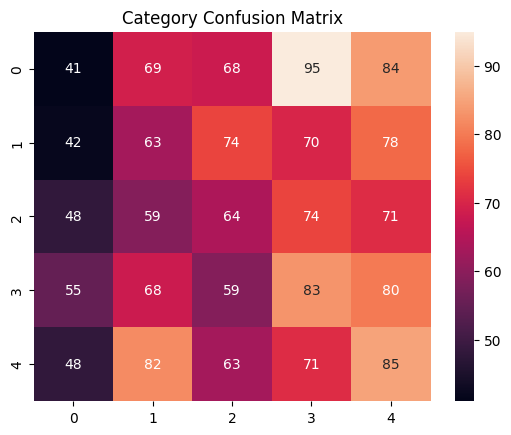

In [9]:
y_category = df['category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y_category, test_size=0.2, random_state=42
)

model_category = LogisticRegression(max_iter=1000)
model_category.fit(X_train, y_train)

y_pred = model_category.predict(X_test)

print("===== CATEGORY CLASSIFICATION =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("Category Confusion Matrix")
plt.show()

In [11]:
y_priority = df['priority']

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X, y_priority, test_size=0.2, random_state=42
)

model_priority = LogisticRegression(max_iter=1000)
model_priority.fit(X_train_p, y_train_p)

def predict_ticket(ticket_text):
    cleaned = clean_text(ticket_text)
    vectorized = vectorizer.transform([cleaned])

    category = model_category.predict(vectorized)[0]
    priority = model_priority.predict(vectorized)[0]

    return category, priority


sample_ticket = "My product stopped working within two days and I need urgent replacement."

cat, pri = predict_ticket(sample_ticket)

print("Ticket:", sample_ticket)
print("Predicted Category:", cat)
print("Predicted Priority:", pri)

Ticket: My product stopped working within two days and I need urgent replacement.
Predicted Category: Product inquiry
Predicted Priority: Critical
